In [42]:
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
import pydotplus
from matplotlib import pyplot as plt
%matplotlib inline

## Первый класс

In [43]:
np.seed = 7
train_data = np.random.normal(size=(100,2))
train_labels = np.zeros(100)

## Второй класс

In [44]:
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]
# np.r_ - смешание строк
# loc - параметр которій принимает функция np.random.normal, является средним для чисел которые должны сгенерироватся.
# Мы конкретинируем эти два массива чтобы потом дерево решений могло их разделить на графике

In [45]:
def get_grid(data, eps=0.01):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, eps),
                     np.arange(y_min, y_max , eps))
# eps - число которое будет отличатся от следующего сгенерированого. Например eps=0.1, числа: 0.1, 0.2, 0.3 ....
# meshgrid - функция которая сделает из двух массивов прямоугольную решётку

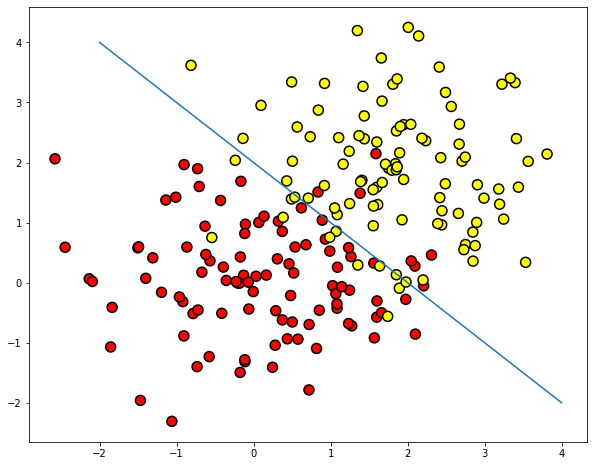

In [46]:
plt.rcParams['figure.figsize'] = (10, 8)
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100,
           cmap='autumn', edgecolors='black', linewidths=1.5)
plt.plot(range(-2, 5), range(4, -3, -1));

### Как видим задача классификации в таком случае сводится к тому чтобы построить линию которая будет разделять два класса точек. В лучшем случае это будет кривая линия которая будет огибать точки разделяя их

### Построим дерево решений которая будет выполнять эту задачу, с помощью установления параметра max_depth

In [47]:
from sklearn.tree import DecisionTreeClassifier

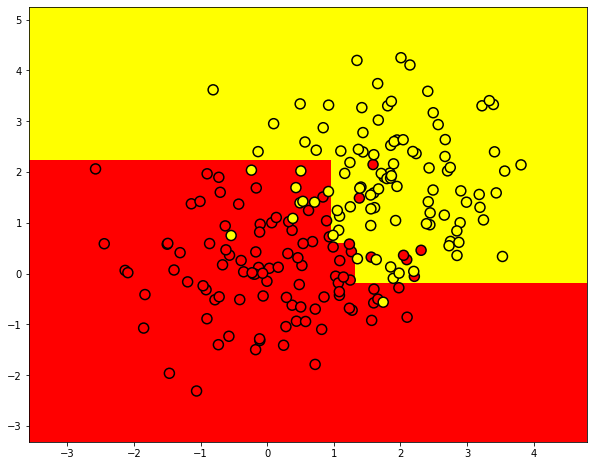

In [48]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=17)


tree.fit(train_data, train_labels)

xx, yy = get_grid(train_data)
predicted = tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100,
           cmap='autumn', edgecolors='black', linewidths=1.5);

### Дерево нарезало пространство на прямоугольники. max_depth - кол-во ступеней которыми разделит пространство дерево. БОЛЬШЕ СТУПЕНЕЙ != ХОРОШО. Если выставить слишком большую максимальную глубину дерева, то оно будет переобучатся на своей выборке, а это значет что оно не будет работать на другой выборке


In [49]:
from PIL import Image
from io import StringIO
from sklearn.tree import export_graphviz
import io



In [50]:
dot_data = StringIO()
export_graphviz(tree, feature_names=['x1', 'x2'],
               out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
img = Image.open(io.BytesIO(graph.create_png()))
img.save('../../jupyter_russian/topic03_decision_trees_knn/telecom.png', format='png')

<img src="telecom.png">

## Работа дерева с количественными признаками

Допустим, в выборке имеется количественный признак "Возраст", имеющий много уникальных значений. Дерево решений будет искать лучшее (по критерию типа прироста информации) разбиение выборки, проверяя бинарные признаки типа "Возраст < 17", "Возраст < 22.87" и т.д. Но что если таких "нарезаний" возраста слишком много? А что если есть еще количественный признак "Зарплата", и зарплату тоже можно "нарезать" большим числом способов? Получается слишком много бинарных признаков для выбора лучшего на каждом шаге построения дерева. Для решения этой проблемы применяют эвристики для ограничения числа порогов, с которыми мы сравниваем количественный признак.

In [51]:
df = pd.DataFrame({'Возраст': [17,64,18,20,38,49,55,25,29,31,33], 
             'Невозврат кредита': [1,0,1,0,1,0,0,1,1,0,1]})

In [53]:
df.sort_values('Возраст')

,Возраст,Невозврат кредита
0,17,1
2,18,1
3,20,0
7,25,1
8,29,1
9,31,0
10,33,1
4,38,1
5,49,0
6,55,0


Обучим на этих данных дерево (без ограничения глубины)

In [64]:
X_train = df['Возраст'].values.reshape(-1, 1)
Y_train = df['Невозврат кредита'].values

In [57]:

age_tree = DecisionTreeClassifier(random_state=17)
age_tree.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=17, splitter='best')

Видим, что дерево задействовало 5 значений, с которыми сравнивается возраст: 43.5, 19, 22.5, 30 и 32 года. Если приглядеться, то это аккурат средние значения между возрастами, при которых целевой класс "меняется" с 1 на 0 или наоборот. Сложная фраза, поэтому пример: 43.5 – это среднее между 38 и 49 годами, клиент, которому 38 лет не вернул кредит, а тот, которому 49 – вернул. Аналогично, 19 лет – среднее между 18 и 20 годами. То есть в качестве порогов для "нарезания" количественного признака, дерево "смотрит" на те значения, при которых целевой класс меняет свое значение.

In [65]:
dot_data = StringIO()
export_graphviz(age_tree, feature_names=['Возраст'],
               out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
img = Image.open(io.BytesIO(graph.create_png()))
img.save('../../jupyter_russian/topic03_decision_trees_knn/age.png', format='png')

<img src="age.png">

### Почему выбрался именно такой возраст? По критєрию неопределённости Джинни (Почти тоже самое что и энтропия Шеннона)
$G = 1 - \sum\limits_k (p_k)^2$

In [67]:
df2 = pd.DataFrame({'Возраст':  [17,64,18,20,38,49,55,25,29,31,33], 
                      'Зарплата': [25,80,22,36,37,59,74,70,33,102,88], 
             'Невозврат кредита': [1,0,1,0,1,0,0,1,1,0,1]}

In [69]:
df2.sort_values('Зарплата')

,Возраст,Зарплата,Невозврат кредита
2,18,22,1
0,17,25,1
8,29,33,1
3,20,36,0
4,38,37,1
5,49,59,0
7,25,70,1
6,55,74,0
1,64,80,0
10,33,88,1


In [73]:
df2.sort_values('Возраст')

,Возраст,Зарплата,Невозврат кредита
0,17,25,1
2,18,22,1
3,20,36,0
7,25,70,1
8,29,33,1
9,31,102,0
10,33,88,1
4,38,37,1
5,49,59,0
6,55,74,0


In [70]:
X_train_sal = df2[['Возраст', 'Зарплата']].values
Y_train_sal = df2['Невозврат кредита'].values

In [71]:
age_sal_tree = DecisionTreeClassifier(random_state=17)
age_sal_tree.fit(X_train_sal, Y_train_sal)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=17, splitter='best')

In [72]:
dot_data = StringIO()
export_graphviz(age_sal_tree, feature_names=['Возраст', 'Зарплата'],
               out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
img = Image.open(io.BytesIO(graph.create_png()))
img.save('../../jupyter_russian/topic03_decision_trees_knn/age_sal.png', format='png')

<img src="age_sal.png">

Видим, что в дереве задействованы как разбиения по возрасту, так и по зарплате. Причем пороги, с которыми сравниваются признаки: 43.5 и 22.5 года – для возраста и 95 и 30.5 тыс. руб/мес – для зарплаты. И опять можно заметить, что 95 тыс. – это среднее между 88 и 102, при этом человек с зарплатой 88 оказался "плохим", а с 102 – "хорошим". То же самое для 30.5 тыс. То есть перебирались сравнения зарплаты и возраста не со всеми возможными значениями, а только с несколькими. А почему в дереве оказались именно эти признаки? Потому что по ним разбиения оказались лучше (по критерию неопределенности Джини)